In [ ]:
#pre-processing video
import cv2
import numpy as np

def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(384, 384)):
  cap = cv2.VideoCapture(path)
  frames = []
  count = 0
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      if count%5 == 0 :
        frame = crop_center_square(frame)
        frame = cv2.resize(frame, resize)      
        frame = frame[:, :, [2, 1, 0]]    
        frames.append(frame)
      count += 1
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

In [ ]:
out = load_video('/content/drive/MyDrive/kinetics600/train_vid/climbing a rope/vid_25_fps.mp4' )
out.shape

(0,)

In [ ]:
#cut the first 16 frames
out2 = out[:16 , :, :, :]
out2.shape
#pass that to the vqgan

(16, 384, 384, 3)

In [ ]:
#mask the last 2 frames  - AFTER VQGAN
out2[14:16, :, :, :] = 3
print(out2[14:16, :, :, :].shape)
out2[13:16, :, :, :]

## 🛠️ Installation and set-up

In [ ]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 235 kB 11.6 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 175 kB 43.8 MB/s 
     |████████████████████████████████| 197 kB 54.0 MB/s 
     |████████████████████████████████| 4.4 MB 45.4 MB/s 
     |████████████████████████████████| 1.8 MB 46.9 MB/s 
     |████████████████████████████████| 596 kB 24.7 MB/s 
     |████████████████████████████████| 140 kB 52.4 MB/s 
     |████████████████████████████████| 217 kB 50.4 MB/s 
     |████████████████████████████████| 51 kB 4.4 MB/s 
     |████████████████████████████████| 72 kB 650 kB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 6.6 MB 53.6 MB/s 
     |████████████████████████████████| 181 kB 61.2 MB/s 
     |████████████████████████████████| 145 kB 61.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [ ]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
# model, params = DalleBart.from_pretrained(
#     DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
# )

# Load VQGAN
vqgan= VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID
)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

Model parameters are replicated on each device for faster inference.

In [ ]:
import io

import requests
from PIL import Image
import numpy as np

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF


def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content))

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = np.clip(x, -1., 1.)
  x = (x + 1.)/2.
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def preprocess(img, target_image_size=256,):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()

def preprocess_img(img, target_image_size=(384,384)):
  
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img.permute(0, 2, 3, 1).numpy()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from PIL import Image 
# def encode_images(img_list):
#   for img_path in img_list:
#       kin_img = Image.open(img_path)
#       kin_img_new = preprocess_img(kin_img)
#       quant_states, indices = vqgan.encode(img)
      

In [ ]:
from PIL import Image 
url='https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1'
size=(224, 224)
size2=(384, 384)
s=384
image = download_image(url)
image = preprocess(image, s)


kin_img = Image.open("/content/drive/MyDrive/0000000070.jpg")
print(kin_img.size)

# img = kin_img.resize(size)
img = TF.resize(kin_img, size2, interpolation=Image.LANCZOS)
img.save("new_tv.jpg")

img = torch.unsqueeze(T.ToTensor()(img), 0)
print(img.shape)
img = img.permute(0, 2, 3, 1).numpy()
print(img.shape)


(202, 360)
torch.Size([1, 3, 384, 384])
(1, 384, 384, 3)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:424: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


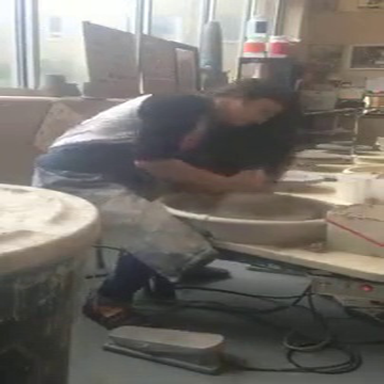

In [ ]:
def stack_reconstructions(input, x0, x1, titles=[]):
  # assert input.size == x1.size == x2.size == x3.size
  w, h = input.size[0], input.size[1]
  img = Image.new("RGB", (5*w, h))
  img.paste(input, (0,0))
  img.paste(x0, (1*w,0))
  img.paste(x1, (2*w,0))
  # img.paste(x2, (3*w,0))
  # img.paste(x3, (4*w,0))
  for i, title in enumerate(titles):
    ImageDraw.Draw(img).text((i*w, 0), f'{title}', (255, 255, 255), font=font) # coordinates, text, color, font
  return img

In [ ]:
quant_states, indices =  vqgan.encode(img) #vqgan.encode(out2)
print("quant_state: ", quant_states.shape)
print("indices: ", indices.shape) 
rec = vqgan.decode(quant_states)
rec2 = vqgan.decode_code(indices)

quant_state:  (1, 24, 24, 256)
indices:  (1, 576)


In [ ]:
print(jax.numpy.amax(indices))
print(jax.numpy.amin(indices))


16314
112


In [ ]:
# quant_states, indices = vqgan.encode(img)
# print("quant_state: ", quant_states.shape)
# print("indices: ", indices.shape) 
# rec = vqgan.decode(quant_states)
# rec2 = vqgan.decode_code(indices)

quant_state:  (1, 14, 14, 256)
indices:  (1, 196)


In [ ]:
from jax import vmap
import jax
def sum_vector(x: np.ndarray) -> np.ndarray:
    """Assumes `x` is a vector"""
    return np.sum(x)
vmap(sum_vector)(quant_states)  
# print(quant_states[1,:,:,:])
print(jax.numpy.amax(quant_states))
print(jax.numpy.amin(quant_states))

# print(jax.numpy.amax(rec))
# print(jax.numpy.amin(rec))


6.439624
-6.2362723


In [ ]:
print(rec.shape)
print(quant_states.shape)

(16, 384, 384, 3)
(16, 24, 24, 256)


In [ ]:
#mask the last 2 frames  - AFTER VQGAN
quant_states_masked= quant_states.at[14:16, :, :, :].set(900)
print(quant_states_masked[13:16, :, :, :])
print(quant_states_masked.shape)

In [ ]:
type(quant_states_masked)

jaxlib.xla_extension.DeviceArray

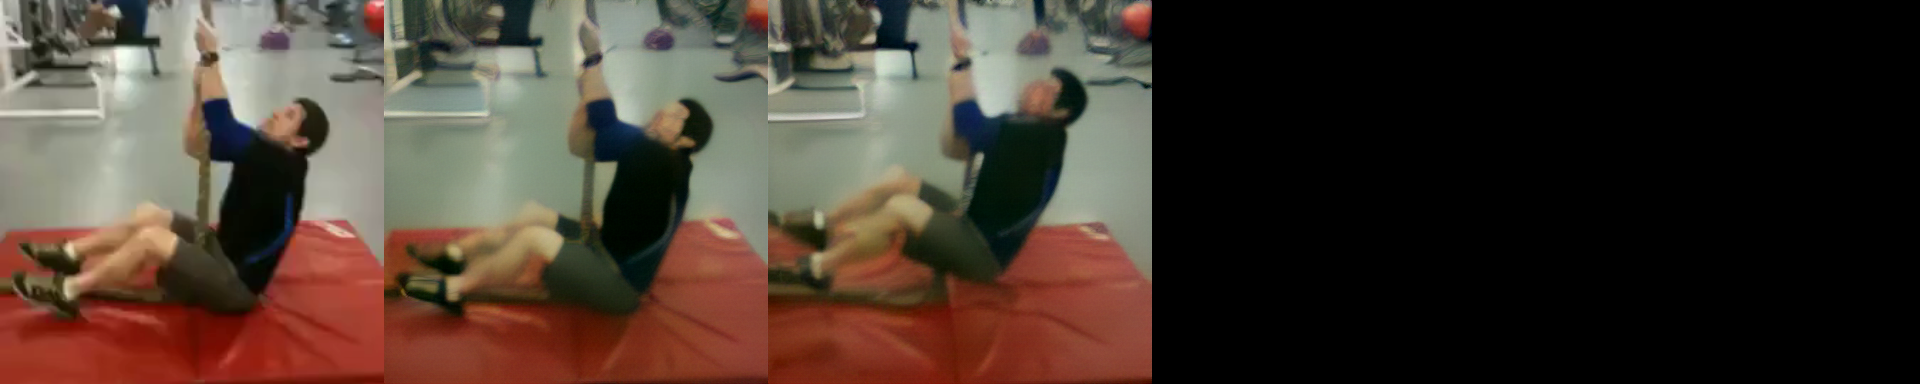

In [ ]:
stack_reconstructions(custom_to_pil(preprocess_vqgan(out2[0])),custom_to_pil(preprocess_vqgan(np.asarray(rec[0]))), custom_to_pil(preprocess_vqgan(np.asarray(rec2[1])))) 


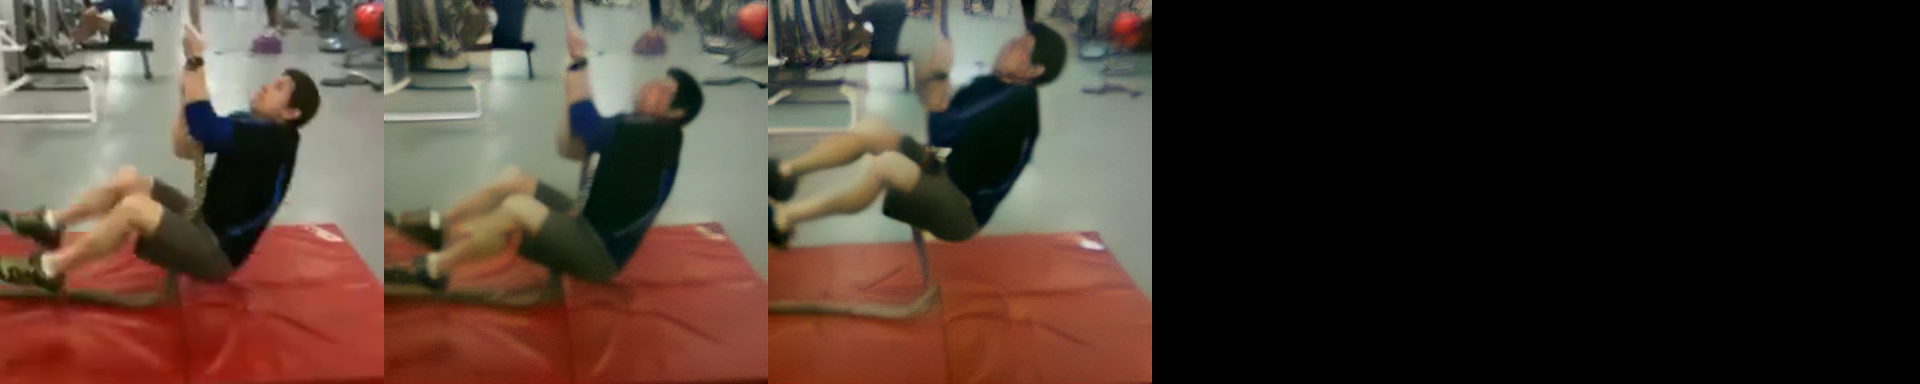

In [ ]:
stack_reconstructions(custom_to_pil(preprocess_vqgan(out2[1])),custom_to_pil(preprocess_vqgan(np.asarray(rec[1]))), custom_to_pil(preprocess_vqgan(np.asarray(rec2[2])))) 


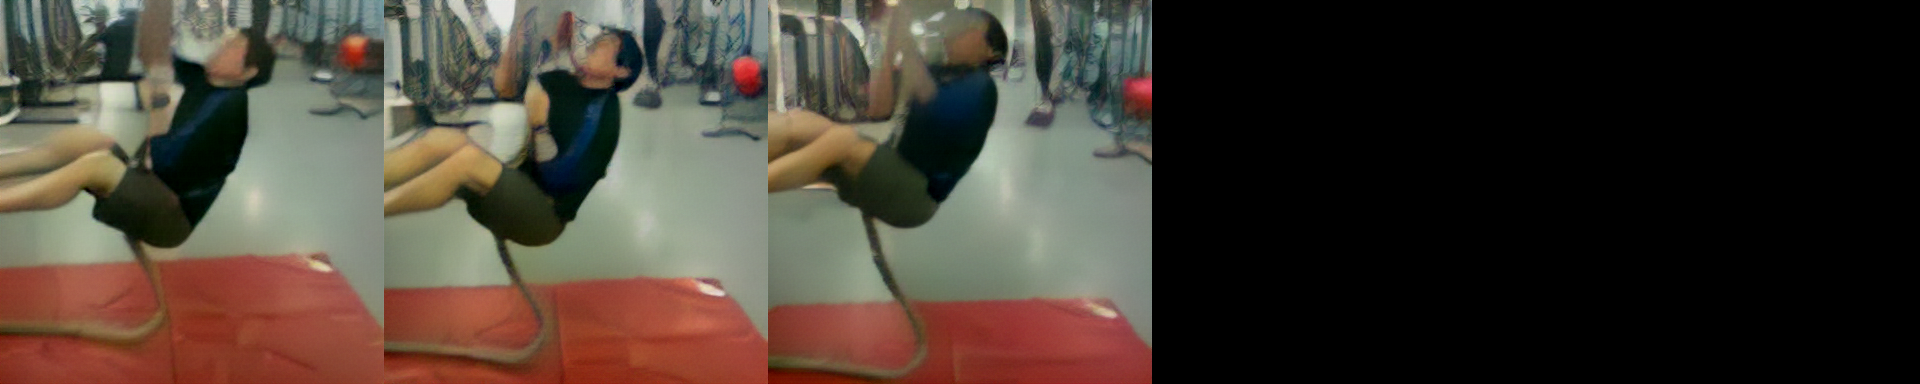

In [ ]:
stack_reconstructions(custom_to_pil(preprocess_vqgan(np.asarray(rec[3]))),custom_to_pil(preprocess_vqgan(np.asarray(rec[4]))), custom_to_pil(preprocess_vqgan(np.asarray(rec2[5])))) 

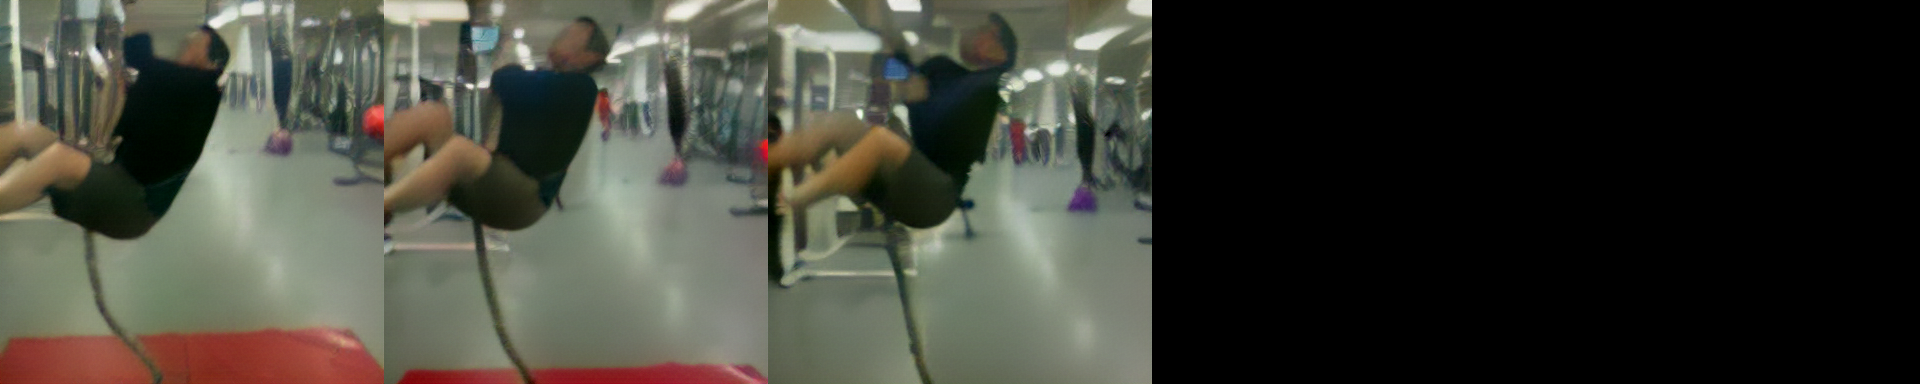

In [ ]:
stack_reconstructions(custom_to_pil(preprocess_vqgan(np.asarray(rec[6]))),custom_to_pil(preprocess_vqgan(np.asarray(rec[7]))), custom_to_pil(preprocess_vqgan(np.asarray(rec2[8])))) 

In [ ]:
from PIL import Image as Img
from PIL import ImageTk

In [ ]:
print(img.shape)
# img = np.squeeze(x, axis=0).shape

(1, 384, 384, 3)


In [ ]:
from PIL import Image
img_n = np.squeeze(img, axis=0)
img_n = Image.fromarray(img_n, 'RGB')
img_n.save('my.png')
img_n.show()


In [ ]:
print(rec[0].shape)

(384, 384, 3)


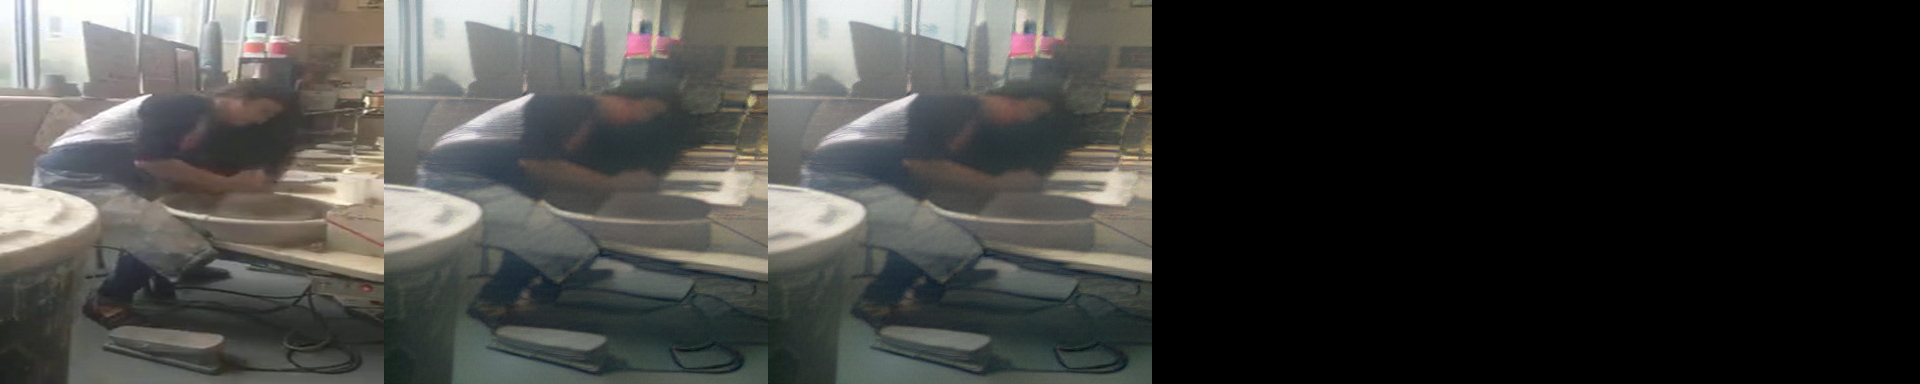

In [ ]:
stack_reconstructions(custom_to_pil(preprocess_vqgan(img[0])),custom_to_pil(preprocess_vqgan(np.asarray(rec[0]))), custom_to_pil(preprocess_vqgan(np.asarray(rec2[0])))) 
                              

# Parallel

In [ ]:
# VQGAN-JAX - pmap encoding HowTo

import numpy as np

# For data loading
import torch
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
from torchvision.transforms import InterpolationMode

# For data saving
from pathlib import Path
import pandas as pd
from tqdm import tqdm

import jax
from jax import pmap

from vqgan_jax.modeling_flax_vqgan import VQModel

## Params and arguments

# List of paths containing images to encode
image_list = '/sddata/dalle-mini/CC12M/10k.tsv'
output_tsv = 'output.tsv'                # Encoded results
batch_size = 64
num_workers = 4    # TPU v3-8s have 96 cores, so feel free to increase this number when necessary

# Load model
model = VQModel.from_pretrained("flax-community/vqgan_f16_16384")

## Data Loading.

# Simple torch Dataset to load images from paths.
# You can use your own pipeline instead.
class ImageDataset(Dataset):
    def __init__(self, image_list_path: str, image_size: int, max_items=None):
        """
        :param image_list_path: Path to a file containing a list of all images. We assume absolute paths for now.
        :param image_size: Image size. Source images will be resized and center-cropped.
        :max_items: Limit dataset size for debugging
        """
        self.image_list = pd.read_csv(image_list_path, sep='\t', header=None)
        if max_items is not None: self.image_list = self.image_list[:max_items]
        self.image_size = image_size
        
    def __len__(self):
        return len(self.image_list)
    
    def _get_raw_image(self, i):
        image_path = Path(self.image_list.iloc[i][0])
        return default_loader(image_path)
    
    def resize_image(self, image):
        s = min(image.size)
        r = self.image_size / s
        s = (round(r * image.size[1]), round(r * image.size[0]))
        image = TF.resize(image, s, interpolation=InterpolationMode.LANCZOS)
        image = TF.center_crop(image, output_size = 2 * [self.image_size])
        image = np.expand_dims(np.array(image), axis=0)
        return image
    
    def __getitem__(self, i):
        image = self._get_raw_image(i)
        return self.resize_image(image)

## Encoding

# Encoding function to be parallelized with `pmap`
# Note: images have to be square
def encode(model, batch):
    _, indices = model.encode(batch)
    return indices

# Alternative: create a batch with num_tpus*batch_size and use `shard` to distribute.
def superbatch_generator(dataloader, num_tpus):
    iter_loader = iter(dataloader)
    for batch in iter_loader:
        superbatch = [batch.squeeze(1)]
        try:
            for _ in range(num_tpus-1):
                batch = next(iter_loader)
                if batch is None:
                    break
                # Skip incomplete last batch
                if batch.shape[0] == dataloader.batch_size:
                    superbatch.append(batch.squeeze(1))
        except StopIteration:
            pass
        superbatch = torch.stack(superbatch, axis=0)
        yield superbatch

def encode_dataset(dataset, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    superbatches = superbatch_generator(dataloader, num_tpus=jax.device_count())
    
    num_tpus = jax.device_count()
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    superbatches = superbatch_generator(dataloader, num_tpus=num_tpus)
    
    p_encoder = pmap(lambda batch: encode(model, batch))

    # Save each superbatch to avoid reallocation of buffers as we process them.
    # Keep the file open to prevent excessive file seeks.
    with open(output_tsv, "w") as file:
        iterations = len(dataset) // (batch_size * num_tpus)
        for n in tqdm(range(iterations)):
            superbatch = next(superbatches)
            encoded = p_encoder(superbatch.numpy())
            encoded = encoded.reshape(-1, encoded.shape[-1])

            # Extract paths from the dataset, save paths and encodings (as string)
            start_index = n * batch_size * num_tpus
            end_index = (n+1) * batch_size * num_tpus
            paths = dataset.image_list[start_index:end_index][0].values
            encoded_as_string = list(map(lambda item: np.array2string(item, separator=',', max_line_width=50000, formatter={'int':lambda x: str(x)}), encoded))
            batch_df = pd.DataFrame.from_dict({"image_file": paths, "encoding": encoded_as_string})
            batch_df.to_csv(file, sep='\t', header=(n==0), index=None)
            
dataset = ImageDataset(image_list, image_size=256)
encoded_dataset = encode_dataset(dataset, batch_size=batch_size)


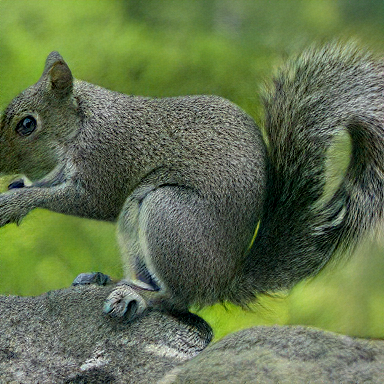

In [ ]:
custom_to_pil(preprocess_vqgan(np.asarray(rec[0])))

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

In [ ]:
# Install dependencies for Google Colab.
# If you want to run this notebook on your own machine, you can skip this cell
!pip install dm-haiku
!pip install einops

!mkdir /content/perceiver
!touch /content/perceiver/__init__.py
!wget -O /content/perceiver/io_processors.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/io_processors.py
!wget -O /content/perceiver/perceiver.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/perceiver.py
!wget -O /content/perceiver/position_encoding.py https://raw.githubusercontent.com/deepmind/deepmind-research/master/perceiver/position_encoding.py


import base64
import functools
import os
import pickle
import ssl
import re
import tempfile

from urllib import request

import cv2
import haiku as hk
import imageio
import jax
import jax.numpy as jnp
import numpy as np
import scipy.io.wavfile

from IPython.display import HTML

from perceiver import perceiver, io_processors


# Helper functions for the UCF101 dataset


In [ ]:
#@title Helper functions for the UCF101 dataset

# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = 'https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/'
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode('utf-8')
    videos = re.findall('(v_[\w_]+\.avi)', index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)

def fetch_ucf_video(video):
  """Fetchs a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print('Fetching %s => %s' % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path

# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)
      
      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=25)
  with open('./animation.gif', 'rb') as f:
    gif_64 = base64.b64encode(f.read()).decode('utf-8')
  return HTML('<img src="data:image/gif;base64,%s"/>' % gif_64)

def play_audio(data, sample_rate=48000):
  scipy.io.wavfile.write('tmp_audio.wav', sample_rate, data)

  with open('./tmp_audio.wav', 'rb') as f:
    audio_64 = base64.b64encode(f.read()).decode('utf-8')
  return HTML('<audio controls src="data:audio/wav;base64,%s"/>' % audio_64)

def table(elements):
  row = ['<td>%s</td>' % el.data for el in elements]
  return HTML('<table><tr>%s</tr></table>' % ''.join(row))

# Load video and audio from UCF

In [ ]:
#@title Load video and audio from UCF

video_names = list_ucf_videos()
video_path = fetch_ucf_video(video_names[0])

# Extract audio using FFMPEG and encode as pcm float wavfile (only format readable by scipy.io.wavfile).
!yes | ffmpeg -i "$video_path"  -c copy  -f wav -map 0:a pcm_f32le -ar 48000 output.wav

sample_rate, audio = scipy.io.wavfile.read("output.wav")
if audio.dtype == np.int16:
  audio = audio.astype(np.float32) / 2**15
elif audio.dtype != np.float32:
  raise ValueError('Unexpected datatype. Model expects sound samples to lie in [-1, 1]')

video = load_video(video_path)

In [ ]:
#@title Kinetics 700 Classes
KINETICS_CLASSES = ["abseiling", "acting in play", "adjusting glasses", "air drumming", 
"alligator wrestling", "answering questions", "applauding", "applying cream", 
"archaeological excavation", "archery", "arguing", "arm wrestling", 
"arranging flowers", "arresting", "assembling bicycle", "assembling computer", 
"attending conference", "auctioning", "baby waking up", "backflip (human)", 
"baking cookies", "bandaging", "barbequing", "bartending", 
"base jumping", "bathing dog", "battle rope training", "beatboxing", 
"bee keeping", "being excited", "being in zero gravity", "belly dancing", 
"bench pressing", "bending back", "bending metal", "biking through snow", 
"blasting sand", "blending fruit", "blowdrying hair", "blowing bubble gum", 
"blowing glass", "blowing leaves", "blowing nose", "blowing out candles", 
"bobsledding", "bodysurfing", "bookbinding", "bottling", 
"bouncing ball (not juggling)", "bouncing on bouncy castle", "bouncing on trampoline", "bowling", 
"braiding hair", "breading or breadcrumbing", "breakdancing", "breaking boards", 
"breaking glass", "breathing fire", "brush painting", "brushing floor", 
"brushing hair", "brushing teeth", "building cabinet", "building lego", 
"building sandcastle", "building shed", "bulldozing", "bungee jumping", 
"burping", "busking", "calculating", "calligraphy", 
"canoeing or kayaking", "capoeira", "capsizing", "card stacking", 
"card throwing", "carrying baby", "carrying weight", "cartwheeling", 
"carving ice", "carving marble", "carving pumpkin", "carving wood with a knife", 
"casting fishing line", "catching fish", "catching or throwing baseball", "catching or throwing frisbee", 
"catching or throwing softball", "celebrating", "changing gear in car", "changing oil", 
"changing wheel (not on bike)", "chasing", "checking tires", "checking watch", 
"cheerleading", "chewing gum", "chiseling stone", "chiseling wood", 
"chopping meat", "chopping wood", "clam digging", "clapping", 
"clay pottery making", "clean and jerk", "cleaning gutters", "cleaning pool", 
"cleaning shoes", "cleaning toilet", "cleaning windows", "climbing a rope", 
"climbing ladder", "climbing tree", "closing door", "coloring in", 
"combing hair", "contact juggling", "contorting", "cooking chicken", 
"cooking egg", "cooking on campfire", "cooking sausages (not on barbeque)", "cooking scallops", 
"cosplaying", "coughing", "counting money", "country line dancing", 
"cracking back", "cracking knuckles", "cracking neck", "crawling baby", 
"crocheting", "crossing eyes", "crossing river", "crying", 
"cumbia", "curling (sport)", "curling eyelashes", "curling hair", 
"cutting apple", "cutting cake", "cutting nails", "cutting orange", 
"cutting pineapple", "cutting watermelon", "dancing ballet", "dancing charleston", 
"dancing gangnam style", "dancing macarena", "deadlifting", "dealing cards", 
"decorating the christmas tree", "decoupage", "delivering mail", "digging", 
"dining", "directing traffic", "disc golfing", "diving cliff", 
"docking boat", "dodgeball", "doing aerobics", "doing jigsaw puzzle", 
"doing laundry", "doing nails", "doing sudoku", "drawing", 
"dribbling basketball", "drinking shots", "driving car", "driving tractor", 
"drooling", "drop kicking", "drumming fingers", "dumpster diving", 
"dunking basketball", "dyeing eyebrows", "dyeing hair", "eating burger", 
"eating cake", "eating carrots", "eating chips", "eating doughnuts", 
"eating hotdog", "eating ice cream", "eating nachos", "eating spaghetti", 
"eating watermelon", "egg hunting", "embroidering", "entering church", 
"exercising arm", "exercising with an exercise ball", "extinguishing fire", "faceplanting", 
"falling off bike", "falling off chair", "feeding birds", "feeding fish", 
"feeding goats", "fencing (sport)", "fidgeting", "filling cake", 
"filling eyebrows", "finger snapping", "fixing bicycle", "fixing hair", 
"flint knapping", "flipping bottle", "flipping pancake", "fly tying", 
"flying kite", "folding clothes", "folding napkins", "folding paper", 
"front raises", "frying vegetables", "gargling", "geocaching", 
"getting a haircut", "getting a piercing", "getting a tattoo", "giving or receiving award", 
"gold panning", "golf chipping", "golf driving", "golf putting", 
"gospel singing in church", "grinding meat", "grooming cat", "grooming dog", 
"grooming horse", "gymnastics tumbling", "hammer throw", "hand washing clothes", 
"head stand", "headbanging", "headbutting", "helmet diving", 
"herding cattle", "high fiving", "high jump", "high kick", 
"historical reenactment", "hitting baseball", "hockey stop", "holding snake", 
"home roasting coffee", "hopscotch", "hoverboarding", "huddling", 
"hugging (not baby)", "hugging baby", "hula hooping", "hurdling", 
"hurling (sport)", "ice climbing", "ice fishing", "ice skating", 
"ice swimming", "inflating balloons", "installing carpet", "ironing", 
"ironing hair", "javelin throw", "jaywalking", "jetskiing", 
"jogging", "juggling balls", "juggling fire", "juggling soccer ball", 
"jumping bicycle", "jumping into pool", "jumping jacks", "jumping sofa", 
"jumpstyle dancing", "karaoke", "kicking field goal", "kicking soccer ball", 
"kissing", "kitesurfing", "knitting", "krumping", 
"land sailing", "laughing", "lawn mower racing", "laying bricks", 
"laying concrete", "laying decking", "laying stone", "laying tiles", 
"leatherworking", "letting go of balloon", "licking", "lifting hat", 
"lighting candle", "lighting fire", "listening with headphones", "lock picking", 
"long jump", "longboarding", "looking at phone", "looking in mirror", 
"luge", "lunge", "making a cake", "making a sandwich", 
"making balloon shapes", "making bubbles", "making cheese", "making horseshoes", 
"making jewelry", "making latte art", "making paper aeroplanes", "making pizza", 
"making slime", "making snowman", "making sushi", "making tea", 
"making the bed", "marching", "marriage proposal", "massaging back", 
"massaging feet", "massaging legs", "massaging neck", "massaging person's head", 
"metal detecting", "milking cow", "milking goat", "mixing colours", 
"moon walking", "mopping floor", "mosh pit dancing", "motorcycling", 
"mountain climber (exercise)", "moving baby", "moving child", "moving furniture", 
"mowing lawn", "mushroom foraging", "needle felting", "news anchoring", 
"opening bottle (not wine)", "opening coconuts", "opening door", "opening present", 
"opening refrigerator", "opening wine bottle", "packing", "paragliding", 
"parasailing", "parkour", "passing American football (in game)", "passing American football (not in game)", 
"passing soccer ball", "peeling apples", "peeling banana", "peeling potatoes", 
"person collecting garbage", "petting animal (not cat)", "petting cat", "petting horse", 
"photobombing", "photocopying", "picking apples", "picking blueberries", 
"pillow fight", "pinching", "pirouetting", "planing wood", 
"planting trees", "plastering", "playing accordion", "playing american football", 
"playing badminton", "playing bagpipes", "playing basketball", "playing bass guitar", 
"playing beer pong", "playing billiards", "playing blackjack", "playing cards", 
"playing cello", "playing checkers", "playing chess", "playing clarinet", 
"playing controller", "playing cricket", "playing cymbals", "playing darts", 
"playing didgeridoo", "playing dominoes", "playing drums", "playing field hockey", 
"playing flute", "playing gong", "playing guitar", "playing hand clapping games", 
"playing harmonica", "playing harp", "playing ice hockey", "playing keyboard", 
"playing kickball", "playing laser tag", "playing lute", "playing mahjong", 
"playing maracas", "playing marbles", "playing monopoly", "playing netball", 
"playing nose flute", "playing oboe", "playing ocarina", "playing organ", 
"playing paintball", "playing pan pipes", "playing piano", "playing piccolo", 
"playing pinball", "playing ping pong", "playing poker", "playing polo", 
"playing recorder", "playing road hockey", "playing rounders", "playing rubiks cube", 
"playing saxophone", "playing scrabble", "playing shuffleboard", "playing slot machine", 
"playing squash or racquetball", "playing tennis", "playing trombone", "playing trumpet", 
"playing ukulele", "playing violin", "playing volleyball", "playing with trains", 
"playing xylophone", "poaching eggs", "poking bellybutton", "pole vault", 
"polishing furniture", "polishing metal", "popping balloons", "pouring beer", 
"pouring milk", "pouring wine", "preparing salad", "presenting weather forecast", 
"pretending to be a statue", "pull ups", "pulling espresso shot", "pulling rope (game)", 
"pumping fist", "pumping gas", "punching bag", "punching person (boxing)", 
"push up", "pushing car", "pushing cart", "pushing wheelbarrow", 
"pushing wheelchair", "putting in contact lenses", "putting on eyeliner", "putting on foundation", 
"putting on lipstick", "putting on mascara", "putting on sari", "putting on shoes", 
"putting wallpaper on wall", "raising eyebrows", "reading book", "reading newspaper", 
"recording music", "repairing puncture", "riding a bike", "riding camel", 
"riding elephant", "riding mechanical bull", "riding mule", "riding or walking with horse", 
"riding scooter", "riding snow blower", "riding unicycle", "ripping paper", 
"roasting marshmallows", "roasting pig", "robot dancing", "rock climbing", 
"rock scissors paper", "roller skating", "rolling eyes", "rolling pastry", 
"rope pushdown", "running on treadmill", "sailing", "salsa dancing", 
"saluting", "sanding floor", "sanding wood", "sausage making", 
"sawing wood", "scrambling eggs", "scrapbooking", "scrubbing face", 
"scuba diving", "seasoning food", "separating eggs", "setting table", 
"sewing", "shaking hands", "shaking head", "shaping bread dough", 
"sharpening knives", "sharpening pencil", "shaving head", "shaving legs", 
"shearing sheep", "shining flashlight", "shining shoes", "shoot dance", 
"shooting basketball", "shooting goal (soccer)", "shooting off fireworks", "shopping", 
"shot put", "shouting", "shoveling snow", "shredding paper", 
"shucking oysters", "shuffling cards", "shuffling feet", "side kick", 
"sieving", "sign language interpreting", "silent disco", "singing", 
"sipping cup", "situp", "skateboarding", "ski ballet", 
"ski jumping", "skiing crosscountry", "skiing mono", "skiing slalom", 
"skipping rope", "skipping stone", "skydiving", "slacklining", 
"slapping", "sled dog racing", "sleeping", "slicing onion", 
"smashing", "smelling feet", "smoking", "smoking hookah", 
"smoking pipe", "snatch weight lifting", "sneezing", "snorkeling", 
"snowboarding", "snowkiting", "snowmobiling", "somersaulting", 
"spelunking", "spinning plates", "spinning poi", "splashing water", 
"spray painting", "spraying", "springboard diving", "square dancing", 
"squat", "squeezing orange", "stacking cups", "stacking dice", 
"standing on hands", "staring", "steer roping", "steering car", 
"sticking tongue out", "stomping grapes", "stretching arm", "stretching leg", 
"sucking lolly", "surfing crowd", "surfing water", "surveying", 
"sweeping floor", "swimming backstroke", "swimming breast stroke", "swimming butterfly stroke", 
"swimming front crawl", "swimming with dolphins", "swimming with sharks", "swing dancing", 
"swinging baseball bat", "swinging on something", "sword fighting", "sword swallowing", 
"tackling", "tagging graffiti", "tai chi", "taking photo", 
"talking on cell phone", "tango dancing", "tap dancing", "tapping guitar", 
"tapping pen", "tasting beer", "tasting food", "tasting wine", 
"testifying", "texting", "threading needle", "throwing axe", 
"throwing ball (not baseball or American football)", "throwing discus", "throwing knife", "throwing snowballs", 
"throwing tantrum", "throwing water balloon", "tickling", "tie dying", 
"tightrope walking", "tiptoeing", "tobogganing", "tossing coin", 
"tossing salad", "training dog", "trapezing", "treating wood", 
"trimming or shaving beard", "trimming shrubs", "trimming trees", "triple jump", 
"twiddling fingers", "tying bow tie", "tying knot (not on a tie)", "tying necktie", 
"tying shoe laces", "unboxing", "uncorking champagne", "unloading truck", 
"using a microscope", "using a paint roller", "using a power drill", "using a sledge hammer", 
"using a wrench", "using atm", "using bagging machine", "using circular saw", 
"using inhaler", "using megaphone", "using puppets", "using remote controller (not gaming)", 
"using segway", "vacuuming car", "vacuuming floor", "visiting the zoo", 
"wading through mud", "wading through water", "waiting in line", "waking up", 
"walking on stilts", "walking the dog", "walking through snow", "walking with crutches", 
"washing dishes", "washing feet", "washing hair", "washing hands", 
"watching tv", "water skiing", "water sliding", "watering plants", 
"waving hand", "waxing armpits", "waxing back", "waxing chest", 
"waxing eyebrows", "waxing legs", "weaving basket", "weaving fabric", 
"welding", "whistling", "windsurfing", "winking", 
"wood burning (art)", "wrapping present", "wrestling", "writing", 
"yarn spinning", "yawning", "yoga", "zumba"]

# Model Construction

In [ ]:
#@title Model construction
NUM_FRAMES = 16
AUDIO_SAMPLES_PER_FRAME = 48000 // 25
SAMPLES_PER_PATCH = 256
NUM_CLASSES = 700
IMG_SZ = 24

def video_autoencoder(images, audio, subsampling):
  n_audio_samples = NUM_FRAMES * AUDIO_SAMPLES_PER_FRAME
  input_preprocessor = io_processors.MultimodalPreprocessor(
      min_padding_size=4,
      modalities={
          'audio': io_processors.AudioPreprocessor(
              position_encoding_type='fourier',
              fourier_position_encoding_kwargs=dict(
                  num_bands=192,
                  max_resolution=(n_audio_samples,),
                  sine_only=False,
                  concat_pos=True,
              ),
              n_extra_pos_mlp=0,
              prep_type='patches',
              samples_per_patch=SAMPLES_PER_PATCH),
          'image': io_processors.ImagePreprocessor(
              position_encoding_type='fourier',
              fourier_position_encoding_kwargs=dict(
                  num_bands=32,
                  max_resolution=(NUM_FRAMES, IMG_SZ, IMG_SZ),
                  sine_only=False,
                  concat_pos=True,
              ),
              n_extra_pos_mlp=0,
              prep_type='patches',
              spatial_downsample=4,
              temporal_downsample=1),
          'label': io_processors.OneHotPreprocessor(),
      },
      mask_probs={'image': 0.0, 'audio': 0.0, 'label': 1.0},
  )

  output_postprocessor = io_processors.MultimodalPostprocessor(
      modalities={
          'audio': io_processors.AudioPostprocessor(
              samples_per_patch=SAMPLES_PER_PATCH),
          'image': io_processors.ProjectionPostprocessor(
              num_outputs=3),
          'label': io_processors.ClassificationPostprocessor(
              num_classes=NUM_CLASSES),
      })

  encoder = encoder = perceiver.PerceiverEncoder(
      num_self_attends_per_block=8,
      # Weights won't be shared if num_blocks is set to 1.
      num_blocks=1,
      z_index_dim=28*28*1,
      num_z_channels=512,
      num_cross_attend_heads=1,
      num_self_attend_heads=8,
      cross_attend_widening_factor=1,
      self_attend_widening_factor=1,
      dropout_prob=0.0,
      z_pos_enc_init_scale=0.02,
      cross_attention_shape_for_attn='kv',
      name='encoder')

  subsampled_index_dims = {
      'audio': subsampling['audio'].shape[0],
      'image': subsampling['image'].shape[0],
      'label': 1,
  }
  image_decoder = perceiver.BasicVideoAutoencodingDecoder(
      # Autoencoding, don't pass inputs to the queries.
      concat_preprocessed_input=False,
      subsampled_index_dims=subsampling['image'],
      output_shape=images.shape[:4],
      num_z_channels=1024,
      output_num_channels=512,
      use_query_residual=False,
      position_encoding_type='fourier',
      fourier_position_encoding_kwargs=dict(
          num_bands=32,
          max_resolution=(NUM_FRAMES, IMG_SZ, IMG_SZ),
          sine_only=False,
          concat_pos=True,
      ),
  )

  decoder = perceiver.MultimodalDecoder(
      # Autoencoding, don't pass inputs to the queries.
      concat_preprocessed_input=False,
      subsampled_index_dims=subsampled_index_dims,
      # Modality specific decoders are used ONLY to generate queries.
      # All modalties are decoded together using a unified decoder.
      modalities={
          'audio': perceiver.BasicDecoder(
              # Autoencoding, don't pass inputs to the queries.
              concat_preprocessed_input=False,
              subsampled_index_dims=subsampling['audio'],
              output_index_dims=(n_audio_samples // SAMPLES_PER_PATCH,),
              num_z_channels=1024,
              output_num_channels=512,
              use_query_residual=False,
              position_encoding_type='fourier',
              fourier_position_encoding_kwargs=dict(
                  num_bands=192,
                  max_resolution=(n_audio_samples,),
                  sine_only=False,
                  concat_pos=True,
              ),
           ),
          'image': image_decoder,
          'label': perceiver.ClassificationDecoder(
              # Autoencoding, don't pass inputs to the queries.
              concat_preprocessed_input=False,
              num_classes=NUM_CLASSES,
              num_z_channels=1024,
              use_query_residual=False,
              position_encoding_type='trainable',
              trainable_position_encoding_kwargs=dict(
                  num_channels=1024,
                  init_scale=0.02,
              ),
          ),
      },
      num_outputs=None,
      output_num_channels=512,
      use_query_residual=False,)
  
  model = perceiver.Perceiver(
      input_preprocessor=input_preprocessor,
      encoder=encoder,
      decoder=decoder,
      output_postprocessor=output_postprocessor)
  
  return model({'image': images,
                'audio': audio,
                'label': np.zeros((images.shape[0], 700))},
               is_training=False, subsampled_output_points=subsampling)


video_autoencoder = hk.transform_with_state(video_autoencoder)

In [ ]:
# #ORIGINAL - ISH
# NUM_FRAMES = 16
# # AUDIO_SAMPLES_PER_FRAME = 48000 // 25
# SAMPLES_PER_PATCH = 16
# NUM_CLASSES = 700
# IMG_SZ = 56

# def video_autoencoder(images, audio, subsampling):


#   encoder = encoder = perceiver.PerceiverEncoder(
#       num_self_attends_per_block=8,
#       # Weights won't be shared if num_blocks is set to 1.
#       num_blocks=1,
#       z_index_dim=28*28*1,
#       num_z_channels=512,
#       num_cross_attend_heads=1,
#       num_self_attend_heads=8,
#       cross_attend_widening_factor=1,
#       self_attend_widening_factor=1,
#       dropout_prob=0.0,
#       z_pos_enc_init_scale=0.02,
#       cross_attention_shape_for_attn='kv',
#       name='encoder')

#   subsampled_index_dims = {
#       'audio': subsampling['audio'].shape[0],
#       'image': subsampling['image'].shape[0],
#       'label': 1,
#   }
#   image_decoder = perceiver.BasicVideoAutoencodingDecoder(
#       # Autoencoding, don't pass inputs to the queries.
#       concat_preprocessed_input=True,
#       subsampled_index_dims=subsampling['image'],
#       output_shape=images.shape[:4],
#       num_z_channels=1024,
#       output_num_channels=512,
#       use_query_residual=False,
#       position_encoding_type='fourier',
#       fourier_position_encoding_kwargs=dict(
#           num_bands=32,
#           max_resolution=(NUM_FRAMES, IMG_SZ, IMG_SZ),
#           sine_only=False,
#           concat_pos=True,
#       ),
#   )


#   decoder = image_decoder

#   # decoder = perceiver.MultimodalDecoder(
#   #     # Autoencoding, don't pass inputs to the queries.
#       # concat_preprocessed_input=False,
#       # subsampled_index_dims=subsampled_index_dims,
#       # Modality specific decoders are used ONLY to generate queries.
#       # All modalties are decoded together using a unified decoder.
#       # modalities={
          
#       #     'image': image_decoder,
#           # 'label': perceiver.ClassificationDecoder(
#           #     # Autoencoding, don't pass inputs to the queries.
#           #     concat_preprocessed_input=False,
#           #     num_classes=NUM_CLASSES,
#           #     num_z_channels=1024,
#           #     use_query_residual=False,
#           #     position_encoding_type='trainable',
#           #     trainable_position_encoding_kwargs=dict(
#           #         num_channels=1024,
#           #         init_scale=0.02,
#           #     ),
#           # ),
#       # },
#       # num_outputs=None,
#       # output_num_channels=512,
#       # use_query_residual=False,)
  
#   model = perceiver.Perceiver(
#       encoder=encoder,
#       decoder=decoder,
#       )
  
#   return model({'image': images},
#               #   'audio': audio,
#               #   'label': np.zeros((images.shape[0], 700))},
#               is_training=False, subsampled_output_points=subsampling
#               )


# video_autoencoder = hk.transform_with_state(video_autoencoder)

# Model Application

In [ ]:
#@title Model application


def autoencode_video(params, state, rng, images, audio):
  nchunks = 128
  reconstruction = {}
  for chunk_idx in range(nchunks):
    image_chunk_size = np.prod(images.shape[1:-1]) // nchunks
    audio_chunk_size = audio.shape[1] // SAMPLES_PER_PATCH // nchunks
    subsampling = {
        'image': jnp.arange(
            image_chunk_size * chunk_idx, image_chunk_size * (chunk_idx + 1)),
        'audio': jnp.arange(
            audio_chunk_size * chunk_idx, audio_chunk_size * (chunk_idx + 1)),
        'label': None,
    }
    output, state = video_autoencoder.apply(
        params, state, rng, images, audio, subsampling)
    reconstruction['label'] = output['label']
    if 'image' not in reconstruction:
      reconstruction['image'] = output['image']
      reconstruction['audio'] = output['audio']
    else:
      reconstruction['image'] = jnp.concatenate(
          [reconstruction['image'], output['image']], axis=1)
      reconstruction['audio'] = jnp.concatenate(
          [reconstruction['audio'], output['audio']], axis=1)
      
  reconstruction['image'] = jnp.reshape(reconstruction['image'], images.shape)
  reconstruction['audio'] = jnp.reshape(reconstruction['audio'], audio.shape)
  return reconstruction

#  Load parameters from checkpoint


In [ ]:

!wget -O video_autoencoding_checkpoint.pystate https://storage.googleapis.com/perceiver_io/video_autoencoding_checkpoint.pystate

rng = jax.random.PRNGKey(42)
with open("video_autoencoding_checkpoint.pystate", "rb") as f:
  params = pickle.loads(f.read())

state = {}

--2022-06-29 21:33:57--  https://storage.googleapis.com/perceiver_io/video_autoencoding_checkpoint.pystate
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79453357 (76M) [application/octet-stream]
Saving to: ‘video_autoencoding_checkpoint.pystate’

video_autoencoding_ 100%[===================>]  75.77M  15.0MB/s    in 5.0s    

2022-06-29 21:34:04 (15.0 MB/s) - ‘video_autoencoding_checkpoint.pystate’ saved [79453357/79453357]



In [ ]:
quant_states_masked[None, :16].shape

(1, 16, 24, 24, 256)

In [ ]:
# Auto-encode the first 16 frames of the video and one of the audio channels
print(params.keys())
# print(params)

reconstruction = autoencode_video(params, state, rng, quant_states_masked[None, :16], audio[None, :16*AUDIO_SAMPLES_PER_FRAME, 0:1])

dict_keys(['classification_decoder/~/basic_decoder/~/trainable_position_encoding', 'projection_postprocessor/linear', 'classification_postprocessor/linear', 'encoder/~/cross_attention/attention/linear', 'encoder/~/cross_attention/attention/linear_1', 'encoder/~/cross_attention/attention/linear_2', 'encoder/~/cross_attention/attention/linear_3', 'encoder/~/cross_attention/mlp/linear', 'encoder/~/cross_attention/mlp/linear_1', 'encoder/~/cross_attention/layer_norm', 'encoder/~/cross_attention/layer_norm_1', 'encoder/~/cross_attention/layer_norm_2', 'encoder/~/self_attention/attention/linear', 'encoder/~/self_attention/attention/linear_1', 'encoder/~/self_attention/attention/linear_2', 'encoder/~/self_attention/attention/linear_3', 'encoder/~/self_attention/mlp/linear', 'encoder/~/self_attention/mlp/linear_1', 'encoder/~/self_attention/layer_norm', 'encoder/~/self_attention/layer_norm_1', 'encoder/~/self_attention_1/attention/linear', 'encoder/~/self_attention_1/attention/linear_1', 'enco

ValueError: ignored

In [ ]:
# Visualize reconstruction of first 16 frames
table([to_gif(reconstruction[0])])